<a href="https://colab.research.google.com/github/lanyu0322/phd_semester1/blob/master/gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

# -- mount google drive
from google.colab import drive
drive.mount("/content/drive")

# -- install geopandas
!pip install geopandas

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 921kB 4.9MB/s 
     |████████████████████████████████| 10.1MB 43.0MB/s 
     |████████████████████████████████| 11.9MB 10.3MB/s 
  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6614 sha256=153e931c3818ca7669a273dc2165626540acdfe92a757109f0e422f970fdeb39
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


**Important import**

In [0]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gp
from shapely.geometry import Point
import pyproj
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
import statistics

**Define the function**

In [0]:
camera_fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", "cams_ft_wd.feather")
camera = pd.read_feather(camera_fname)
cam_len = len(camera)

# -- define helper function for integrating within a circle
def integrate_geodata(geo, vals, lat, lon, rad):
  
  # -- convert lat/lon to NY State Plane
  ll_nyspd = pyproj.Proj(init="epsg:2263", preserve_units=True)(lon, lat)
  
  # -- define a circle
  circ = Point(ll_nyspd[0], ll_nyspd[1]).buffer(rad)
  
  # -- calculate the intersection of the circle with the geometry
  inter = geo.intersection(circ)
  
  # -- determine the overlap fraction
  frac = inter.area / geo.area
  return (frac * vals).sum() 

def convert_to_nyc(data):
  if (data.geometry.crs["init"] != "epsg:2263"):
    data.geometry = data.geometry.to_crs(epsg=2263)

**1.get the park area within 500 ft**

init park epsg:  {'init': 'epsg:4326'}
converted park epsg:  {'init': 'epsg:2263', 'no_defs': True}


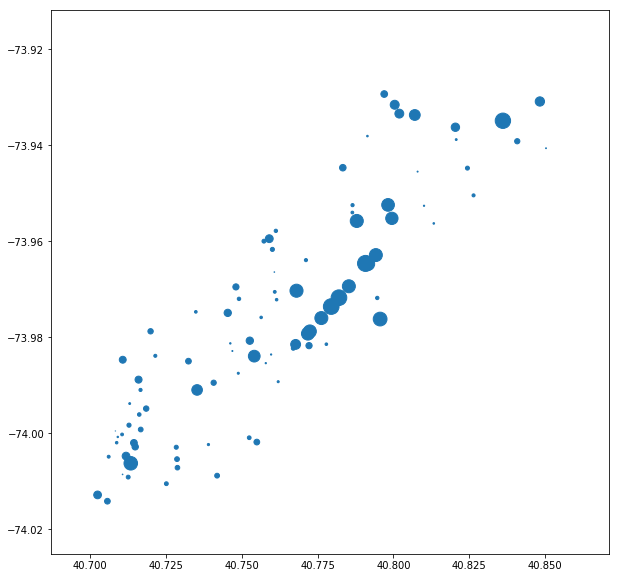

In [0]:
# for each camera:
park_fname = os.path.join("drive", "My Drive", "lwir", "data", "parks", "properties", "geo_export_5b605687-0f81-4fe4-9fb7-ec27cd43ab5f.shp")
park_data = gp.read_file(park_fname)
print("init park epsg: ", park_data.geometry.crs)

convert_to_nyc(park_data)
print("converted park epsg: ", park_data.geometry.crs)

# -- get the parks area within a radius
park_area = np.array([integrate_geodata(park_data.geometry, park_data.area, camera.lat[i], camera.lon[i], 500.) for i in range(cam_len)])

plt.figure(figsize=(10, 10))
plt.scatter(camera.lat, camera.lon, s=park_area/2000.)


**2. get the w+r within 500ft**

init w+r epsg:  {'init': 'epsg:4269'}
converted w+r epsg:  {'init': 'epsg:2263', 'no_defs': True}


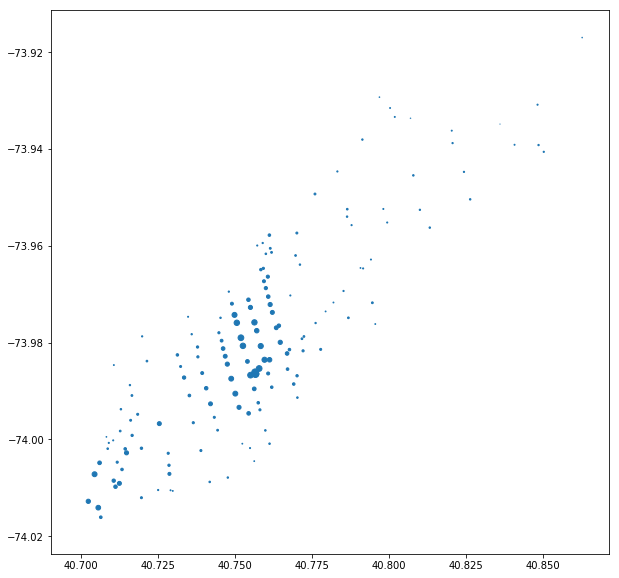

In [0]:
wname = "drive/My Drive/lwir/data/nyc_ratio/ny_wac_S000_JT00_2017.csv"
rname = "drive/My Drive/lwir/data/nyc_ratio/ny_rac_S000_JT00_2017.csv"
wdata = pd.read_csv(wname)
rdata = pd.read_csv(rname)
wdata.rename(columns = {'w_geocode': 'GEOID10'}, inplace=True)
rdata.rename(columns = {'h_geocode': 'GEOID10'}, inplace=True)
lehd = pd.merge(wdata[["GEOID10", "C000"]], rdata[["GEOID10", "C000"]], 
               on="GEOID10", suffixes=["_w", "_h"], how="outer").fillna(0)
lehd["total_p"] = lehd["C000_w"] + lehd["C000_h"]

dpath   = os.path.join("drive", "My Drive", "lwir", "data", "nyc_ratio", "tl_2019_36_tabblock10/tl_2019_36_tabblock10.shp")
ct_full = gp.read_file(dpath)

# -- convert geographic ID to integer
ct_full["GEOID10"] = ct_full["GEOID10"].astype(int)

# -- sub-select only New York City Counties
cnums  = ["005", "047", "061", "081", "085"]
ind    = ct_full.COUNTYFP10.isin(cnums)
ct_nyc = ct_full[ind]

# -- merge LEHD data and geographic data
lehd_ct = ct_nyc.merge(lehd, on="GEOID10")
print("init w+r epsg: ", lehd_ct.geometry.crs)
convert_to_nyc(lehd_ct)
print("converted w+r epsg: ", lehd_ct.geometry.crs)
wrtot = np.zeros(cam_len)
for i in range(cam_len):
  wrtot[i] = integrate_geodata(lehd_ct.geometry, lehd_ct.total_p, camera.lat[i], 
                                camera.lon[i], 500.)
plt.figure(figsize=(10, 10))
plt.scatter(camera.lat, camera.lon, s=wrtot/1000.)


**3.get the integrated number of counts between 8AM and 10AM**

In [0]:
def integrate_time_series(camera, start_index, end_index):
  result = []
  for j in range(len(camera)): 
    sum = 0 
    for i in range(start_index, end_index):
      sum += camera.iat[j,i]
    result.append(sum)
  return result

eight_to_ten = 0
print(camera.head())
for i in range(len(camera)):
  for j in range(35,43):         #35 因为camera最前面还有3个column:cam_id, lat, lon， 然后才是0，1，2，... 8点的index本应该是32, 加上3就是35
    eight_to_ten += camera.iat[i,j]
print(eight_to_ten)
eight_ten = integrate_time_series(camera, 35, 43) 
print(eight_ten)

   cam_id        lat        lon  ...        93        94        95
0     172  40.716623 -73.999186  ...  0.492537  0.542913  0.451564
1     421  40.761268 -73.983564  ...  1.767610  1.668866  1.504888
2     514  40.770207 -73.986869  ...  0.040762  0.044282  0.055718
3     838  40.718427 -73.994830  ...  0.613099  0.580427  0.555230
4     910  40.786516 -73.952456  ...  0.269355  0.280303  0.228795

[5 rows x 99 columns]
3739.9836252278174
[11.111751510138607, 34.374442940571974, 2.546037296037296, 36.92118472924925, 14.659260094743967, 13.770917254788223, 19.062420733388475, 61.92432424206618, 17.537738426448104, 41.02175226207484, 74.28446750382234, 64.29841592099656, 55.99176253853673, 42.618597889565635, 65.1651552748327, 11.784388550517583, 6.467908614682809, 14.85019299696719, 1.4283906058099605, 3.4536895004636943, 34.26181041181041, 8.189053061633707, 10.55967491290072, 68.52835802190643, 7.920760959470636, 13.69357345163797, 29.64505439005439, 8.906857658470562, 47.59306088177

**4.get the integrated number of counts between 11AM and 1PM**

In [0]:
eleven_to_thirteen = 0
for i in range(len(camera)):
  for j in range(47,55): 
    eleven_to_thirteen += camera.iat[i,j]
    
print(eleven_to_thirteen)
eleven_thirteen = integrate_time_series(camera, 47, 55)
print(eleven_thirteen)

3925.2674253460304
[18.529920885566046, 27.736396578332062, 2.3604802008027814, 30.631288961934125, 10.712969199259524, 9.745946526591688, 23.723715084198954, 67.01449339191275, 10.520597860920443, 44.91945885655563, 75.52365573494606, 64.07402892806118, 62.77109216947926, 40.70842088019507, 65.47385293917553, 13.993976990751184, 7.549163112872789, 17.354234385686, 1.0889724075207947, 2.78779598537663, 35.834028068705486, 8.142851950916466, 10.993908600360212, 55.97424493069654, 10.770469405146825, 16.662903494355106, 43.72002136752137, 11.12822786532464, 43.79366448963223, 32.17044541480025, 46.73947709996098, 40.470723541691285, 12.847234664976598, 9.850064362161136, 62.52578237175011, 30.752432066141743, 81.33377984023144, 35.726694004919814, 56.04823491920267, 31.190348719380975, 26.12955932955933, 24.30282369959789, 95.233991814637, 11.94904163936422, 19.351638952445402, 6.453471528471528, 29.324549285839606, 8.41022436345017, 12.015808474679442, 36.70766097701582, 18.490435371080

In [0]:
eight_ten_array = np.array(eight_ten)
eleven_thirteen_array = np.array(eleven_thirteen)
rat = eight_ten_array / eleven_thirteen_array
print(rat)
len(rat)
len(camera)

[0.59966535 1.2393262  1.07860989 1.20534218 1.36836575 1.41298921
 0.80351752 0.92404376 1.66699067 0.91322899 0.98359205 1.003502
 0.89199918 1.04692339 0.99528518 0.84210433 0.85677161 0.85571006
 1.31168668 1.2388602  0.95612501 1.00567382 0.96050234 1.22428374
 0.73541465 0.82179996 0.67806587 0.80038419 1.08675676 0.68711864
 1.06659692 1.25543796 0.9321132  1.16781798 0.90024328 0.95284183
 1.1822064  0.90965623 0.93090336 0.93340031 0.95708442 1.25617684
 1.03905662 1.28203215 0.97066678 0.97848385 1.08402031 1.1122042
 0.77618764 0.95414604 0.92344715 0.86844927 0.65070357 0.79591899
 1.29778242 0.97666117 0.79477538 1.00841543 1.07384078 0.89912213
 1.01579659 0.84834538 0.87944619 1.08928192 0.69992904 0.99419395
 1.49536985 0.95656106 1.05195379 0.54620777 0.81381336 1.04126118
 0.77007205 0.96155928 1.06474459 1.00175988 0.98068351 1.03561842
 0.93571859 0.38372607 1.14966405 1.00388274 1.13729761 1.02222187
 1.22701521 1.17456736 0.85721205 0.81981768 1.11702494 1.0230661

157

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  2.,  1.,
         2.,  3.,  1.,  3.,  4.,  7.,  5.,  2.,  6.,  7.,  8.,  8.,  9.,
        13.,  7.,  8.,  6.,  6.,  4.,  5.,  2.,  3.,  4.,  4.,  2.,  3.,
         4.,  2.,  2.,  2.,  2.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.38372607, 0.40553007, 0.42733407, 0.44913807, 0.47094208,
        0.49274608, 0.51455008, 0.53635408, 0.55815808, 0.57996209,
        0.60176609, 0.62357009, 0.64537409, 0.6671781 , 0.6889821 ,
        0.7107861 , 0.7325901 , 0.75439411, 0.77619811, 0.79800211,
        0.81980611, 0.84161012, 0.86341412, 0.88521812, 0.90702212,
        0.92882613, 0.95063013, 0.97243413, 0.99423813, 1.01604213,
        1.03784614, 1.0596

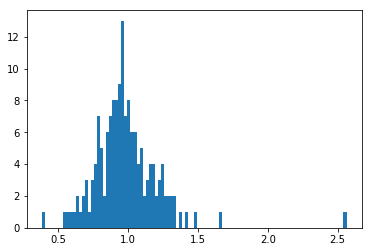

In [0]:
plt.hist(rat, bins=100)

In [0]:
print(np.median(rat))

print(rat.std())


0.9605023378632359
0.23141809026919896


In [0]:
rat.

**5.get the integrated number of counts between 4PM and 6PM**

In [0]:
sisteen_to_eighteen = 0
for i in range(len(camera)):
  for j in range(67,75): 
    sisteen_to_eighteen += camera.iat[i,j]
print(sisteen_to_eighteen)
sisteen_eighteen = integrate_time_series(camera, 67, 75)
print(sisteen_eighteen)

4701.412553041346
[23.192553324811385, 45.09090157154672, 3.0591823946662657, 34.49975938040454, 14.480086222021704, 15.798244228889393, 25.390768729478406, 77.66757525628493, 14.475879138782366, 59.19004937714615, 88.13618567812115, 83.57865754317366, 70.76968694388049, 51.983388475323956, 76.95973882748075, 13.81021505376344, 6.3221733463668945, 17.775489385166804, 2.509370378725217, 4.537465849562624, 37.689232273103244, 8.738225931774318, 13.217995087349927, 70.49592701205604, 13.551180539890215, 25.518090332606462, 44.850484330484335, 12.190728626212497, 50.26554126876708, 40.05682632779407, 63.22903727097275, 49.54774419129258, 14.924361480813094, 11.199680427099782, 71.52319597964758, 37.0382296914555, 87.29421009098428, 43.524554477780285, 61.28922600696794, 41.11709025741284, 31.93057372734792, 30.53045091109607, 91.22579517256936, 17.40230217810863, 21.72004536681956, 9.276667418602901, 43.52092387898839, 7.737630648920971, 14.83990400280723, 43.65908150988796, 24.59838333709

**6.fit each time series with a mixture of 3 Gaussians**

In [0]:
counts = camera.drop(columns=["cam_id", "lat", "lon"]).iloc[0].values


[418.62884031738866, 459.55768212074634, 501.7396844374265, 520.9825068748455, 492.5099772091708, 468.40682934747434, 443.76464138012517, 434.3934635406412]
[412.71294239298845, 427.34320843519, 457.87271227876084, 483.1696662733065, 515.8297485698293, 534.7138025415445, 546.4582221951114, 547.1671226593]
[555.3455768544477, 546.4384217753574, 557.4974890432153, 557.6360650818715, 606.2738966409935, 615.0605024992925, 630.5987214577538, 632.5618796884123]
467.49795315347734 490.65842816825386 587.676569130168
35.395593884614286 53.58120868916868 36.862348733037024


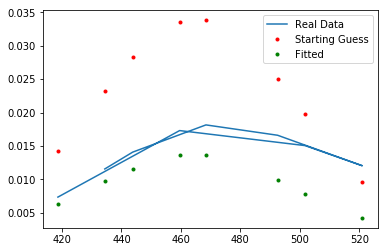

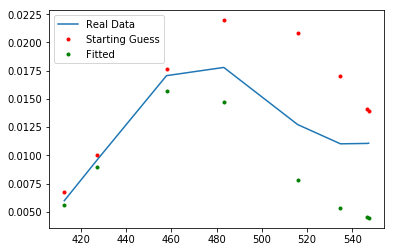

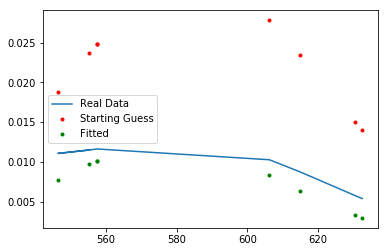

In [0]:

# eight_ten = integrate_time_series(camera, 35, 43) #integrated，list
# eleven_thirteen = integrate_time_series(camera, 47, 55)
# sisteen_eighteen = integrate_time_series(camera, 67, 75)
# print(eight_ten)
# print(eleven_thirteen)
# print(sisteen_eighteen)

######################################
# Setting up test data
def norm(x, mean, sd):
  norm = []
  for i in range(len(x)):
    norm.append(1.0/(sd*np.sqrt(2*np.pi))*np.exp(-(x[i] - mean)**2/(2*sd**2)))
  return np.array(norm)

mean1, mean2, mean3= statistics.mean(eight_ten), statistics.mean(eleven_thirteen), statistics.mean(sisteen_eighteen)
std1, std2, std3= statistics.stdev(eight_ten), statistics.stdev(eleven_thirteen), statistics.stdev(sisteen_eighteen) 

print(mean1, mean2, mean3)
print(std1, std2, std3)

y_real_1 = norm(eight_ten, mean1, std1) + norm(eight_ten, mean2, std2) + norm(eight_ten, mean3, std3)

######################################
# Solving
m, dm, sd1, sd2, sd3 = [460, 5, 35, 35, 35]
p = [m, dm, sd1, sd2, sd3] # Initial guesses for leastsq https://blog.csdn.net/weixin_37203756/article/details/80550886

def res(p, y, x):
  m, dm, sd1, sd2, sd3 = p
  m1 = m
  m2 = m1 + dm
  m3 = m2 + dm
  y_fit = norm(x, m1, sd1) + norm(x, m2, sd2) + norm(x, m3, sd3)
  err = y - y_fit
  return err

y_init = norm(eight_ten, m, sd1) + norm(eight_ten, m + dm, sd2) + norm(eight_ten, m + dm + dm, sd3)# For final comparison plot
plsq = leastsq(res, p, args = (y_real_1, eight_ten))
y_est = norm(eight_ten, plsq[0][0], plsq[0][2]) + norm(eight_ten, plsq[0][0] + plsq[0][1], plsq[0][3])

plt.plot(eight_ten, y_real_1, label='Real Data')
plt.plot(eight_ten, y_init, 'r.', label='Starting Guess')
plt.plot(eight_ten, y_est, 'g.', label='Fitted')
plt.legend()
plt.show()

m, dm, sd1, sd2, sd3 = [490, 5, 53, 53, 53]
p2 = [m, dm, sd1, sd2, sd3]

y_real_2 = norm(eleven_thirteen, mean1, std1) + norm(eleven_thirteen, mean2, std2) + norm(eleven_thirteen, mean3, std3)
y_init_2 = norm(eleven_thirteen, m, sd1) + norm(eleven_thirteen, m + dm, sd2) + norm(eleven_thirteen, m + dm + dm, sd3)# For final comparison plot
plsq = leastsq(res, p2, args = (y_real_2, eleven_thirteen))
y_est_2 = norm(eleven_thirteen, plsq[0][0], plsq[0][2]) + norm(eleven_thirteen, plsq[0][0] + plsq[0][1], plsq[0][3])

plt.plot(eleven_thirteen, y_real_2, label='Real Data')
plt.plot(eleven_thirteen, y_init_2, 'r.', label='Starting Guess')
plt.plot(eleven_thirteen, y_est_2, 'g.', label='Fitted')
plt.legend()
plt.show()


m, dm, sd1, sd2, sd3 = [580, 5, 36, 36, 36]
p3 = [m, dm, sd1, sd2, sd3]
y_real_3 = norm(sisteen_eighteen, mean1, std1) + norm(sisteen_eighteen, mean2, std2) + norm(sisteen_eighteen, mean3, std3)
y_init_3 = norm(sisteen_eighteen, m, sd1) + norm(sisteen_eighteen, m + dm, sd2) + norm(sisteen_eighteen, m + dm + dm, sd3)# For final comparison plot
plsq = leastsq(res, p3, args = (y_real_3, sisteen_eighteen))
y_est_3 = norm(eleven_thirteen, plsq[0][0], plsq[0][2]) + norm(sisteen_eighteen, plsq[0][0] + plsq[0][1], plsq[0][3])

plt.plot(sisteen_eighteen, y_real_3, label='Real Data')
plt.plot(sisteen_eighteen, y_init_3, 'r.', label='Starting Guess')
plt.plot(sisteen_eighteen, y_est_3, 'g.', label='Fitted')
plt.legend()
plt.show()

